# Úkol č. 1 - předzpracování dat a binární klasifikace

  * **Deadline je do 3. 11. 2022, 23:59:59**, pokud odevzdáte úkol do 10. 11. 2022, 23:59:59, budete penalizování -4 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **12 bodů**:
  * Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.
  * V notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny potřebné k trénování a evaluaci modelu (optimálně tedy trénovací, validační a testovací).
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit. Pro průzkum dat využívejte vizualizace.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 16 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte na testovací množině. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zaměřte se na optimální předzpracování dat. Zabývejte se tím, jak nejlépe zpracovat a reprezentovat kategoriální příznaky. Také zkuste data normalizovat. Zaměřte se na vliv těchto kroků na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.
  * Vytvořte i csv soubor s predikcemi a uložte ho v rámci projektu (`results.csv`, vedle ipython notebooku).
  * Opravující Vám ve výjimečných případech může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale stěžejní a má hlavní vliv na hodnocení.

### Data: základní přehled
* Použiju balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.


In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data.csv')

In [3]:
print('data shape: ' + str(data.shape))
display(data.head())
display(data.info())
display(data.describe())
display(data.nunique())

data shape: (1000, 13)


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,NaN
1,1,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S,"Australia Fingal, ND"
2,2,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S,Belfast
3,3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,NaN
4,4,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C,"New York, NY"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      222 non-null    object 
 11  embarked   999 non-null    object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


None

,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.000000,1000.000000,797.000000,1000.000000,1000.000000,999.000000
mean,499.500000,0.391000,2.293000,30.006692,0.499000,0.384000,33.418514
std,288.819436,0.488219,0.840153,14.240416,1.020314,0.873675,53.115334
min,0.000000,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,249.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,499.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,749.250000,1.000000,3.000000,38.500000,1.000000,0.000000,31.275000
max,999.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


ID           1000
survived        2
pclass          3
name          999
sex             2
age            94
sibsp           7
parch           7
ticket        754
fare          249
cabin         156
embarked        3
home.dest     314
dtype: int64

### Příprava dat před použitím modelu
* Zbavím se sloupců `ID` a `name`, protože informace v nich obsažené nijak neovlivňují statistiky přežití cestujících.

In [4]:
data = data.drop(['ID', 'name'], axis=1)
# pokud jsou v souboru duplicitní řádky dat, odstraním jich
data = data.drop_duplicates()

### Chybějící hodnoty
*  Některé příznaky jsou nevyplněné, ale `pandas` hlásí, že žádné nechybí. Může se stát, že chybějící hodnoty nejsou správně zakódovány a místo `NaN` bude otazník `?` nebo pomlčka `'-'` nebo bude uvedeno `'unknown'`/`'Unknown'`.
* V tomto případě nahrazuju případné chyby při plnění souboru na `np.nan`.

In [5]:
data = data.replace('?', np.nan)
data = data.replace('-', np.nan)
data = data.replace('unknown', np.nan)
data = data.replace('Unknown', np.nan)

Implementace rozhodovacího stromu v `sklearn` si neumí poradit s nenumerickými příznaky. Proto nahradím stringy jejich kódy.

In [6]:
display(data.dtypes)

survived       int64
pclass         int64
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

Nahradím **'male'** a **'female'** na bool hodnoty. Nastavila jsem jestli `xtrain.sex == 'male'` - pak je to True, jinak je to False.
Tj příznak **'male'** bude převeden na hodnotu True a **'female'** na False.

In [7]:
data.sex = (data.sex == 'male')

Nečíselný příznak `embarked` je **nominální** a převedu ho na **one-hot encoding** reprezentaci.

In [8]:
data = pd.get_dummies(data, columns=['embarked'])

Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Všechny nahradím číselnými kódy.
  * Ještě je převedu na číselnou reprezentaci pomocí `...cat.codes`


In [9]:
obj_columns = data.select_dtypes('object').columns
data[obj_columns] = data[obj_columns].astype('category').apply(lambda x: x.cat.codes)

Na závěr nahradím všechny chybějící hodnoty -1.

In [10]:
data = data.fillna('-1')

### Příprava trénovací a validační množiny pro učení stromu
Nejprve oddělím cílovou proměnnou, kterou chci predikovat.
V našem případě se jedná o `survived`


In [11]:
xdata = data.drop('survived', axis=1)
ydata = data.survived

Postupně vytvořím **trénovací**, **validační** a **testovací** část dat.

Data rozdělím tak, aby 60% bylo trénovací, 20% validační a 20% testovací.


In [12]:
rd_seed = 444
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.4, random_state=rd_seed)

print('původní data')
print(xdata.shape)
print(ydata.shape)
print('trénovací data')
print(xtrain.shape)
print(ytrain.shape)
print('testovací data')
print(xtest.shape)
print(ytest.shape)

původní data
(987, 12)
(987,)
trénovací data
(592, 12)
(592,)
testovací data
(395, 12)
(395,)


In [13]:
xval, xtest, yval, ytest = train_test_split(xtest, ytest, test_size=0.5, random_state=rd_seed)

print('nové testovací data')
print(xtest.shape)
print(ytest.shape)
print('validační data')
print(xval.shape)
print(yval.shape)

nové testovací data
(198, 12)
(198,)
validační data
(197, 12)
(197,)


### Použití rozhodovacího stromu implementovaného v `sklearn`

In [14]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=50)
display(dtc.get_params())
dtc.fit(xtrain, ytrain)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

DecisionTreeClassifier(max_depth=50)

In [15]:
# jak vypadá výsledný strom
from sklearn.tree import plot_tree
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plt.figure(figsize=(10,10))
# plot_tree(dtc, filled=True, feature_names=xtrain.iloc[:,:].columns, class_names=True, rounded=True)

* Vytvoření stromu trvá v průměru 25 sekund, proto jsem tyto řádky okomentovala, abych dlouho nečekala, než bude zpracován celý jupyter.

In [16]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dtc.predict(xtrain))))

accuracy score (train): 1.000000


* Přesnost na trénovacích datech je  (pro `max_depth` = 50) je 100 %
* Ale s testovacími daty to tak skvěle nedopadne:

In [17]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dtc.predict(xtest))))

accuracy score (test): 0.808081


### Ladění hyperparameterů `max_depth` a `criterion`
* Začnu s hyperparametrem `max_depth`
* Budu používat validační množinu.

In [18]:
val_accuracy = []
train_accuracy = []

depths = range(1,100)
for depth in depths:
    dtc = DecisionTreeClassifier(max_depth=depth)
    dtc.fit(xtrain, ytrain)
    train_accuracy.append(metrics.accuracy_score(ytrain, dtc.predict(xtrain)))
    val_accuracy.append(metrics.accuracy_score(yval, dtc.predict(xval)))

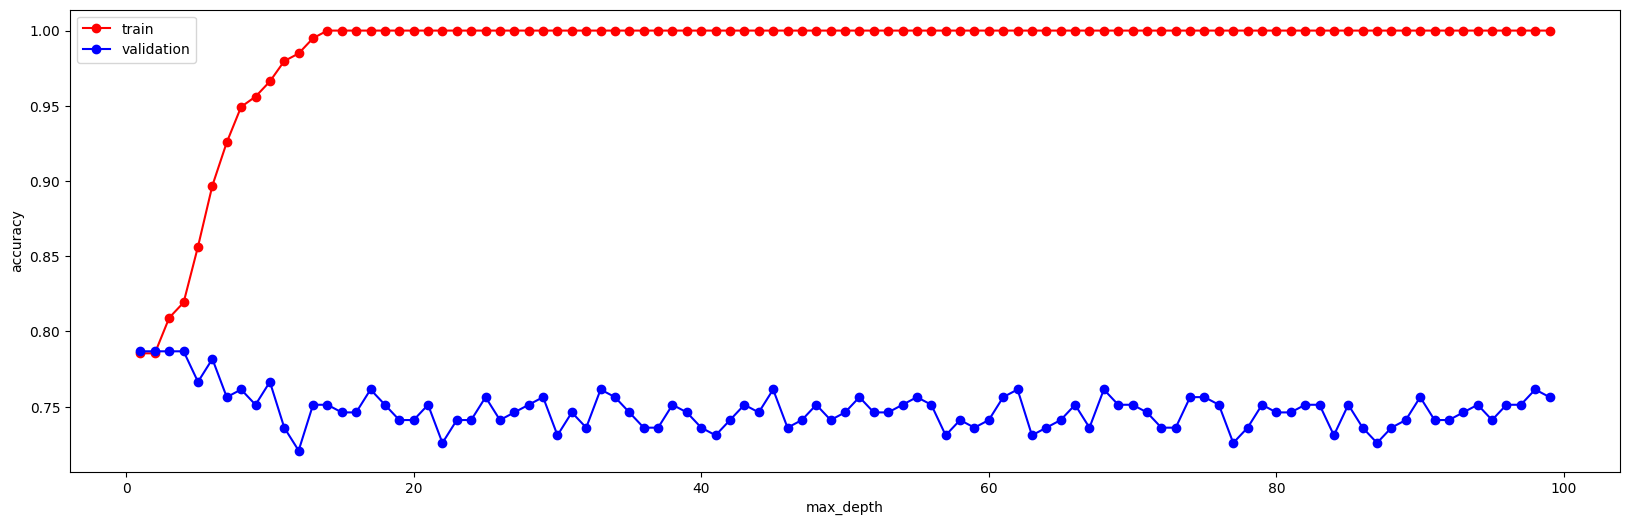

In [19]:
plt.figure(figsize=(20,6))
plt.plot(depths, train_accuracy,'or-')
plt.plot(depths, val_accuracy,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [20]:
optimal_depth = np.argmax(val_accuracy) + 1
optimal_depth

1

Spočítám **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [21]:
dtc = DecisionTreeClassifier(max_depth=optimal_depth)
dtc.fit(xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dtc.predict(xtest))))

accuracy score (test): 0.772727


### Grid search: ladění více hyperparameterů
Chci projít hodnoty `max_depth` a obě možné hodnoty `criterion`.

In [22]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

In [23]:
val_accuracy = []
train_accuracy = []

for params in param_comb:
    dtc = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dtc.fit(xtrain, ytrain)
    train_accuracy.append(metrics.accuracy_score(ytrain, dtc.predict(xtrain)))
    val_accuracy.append(metrics.accuracy_score(yval, dtc.predict(xval)))

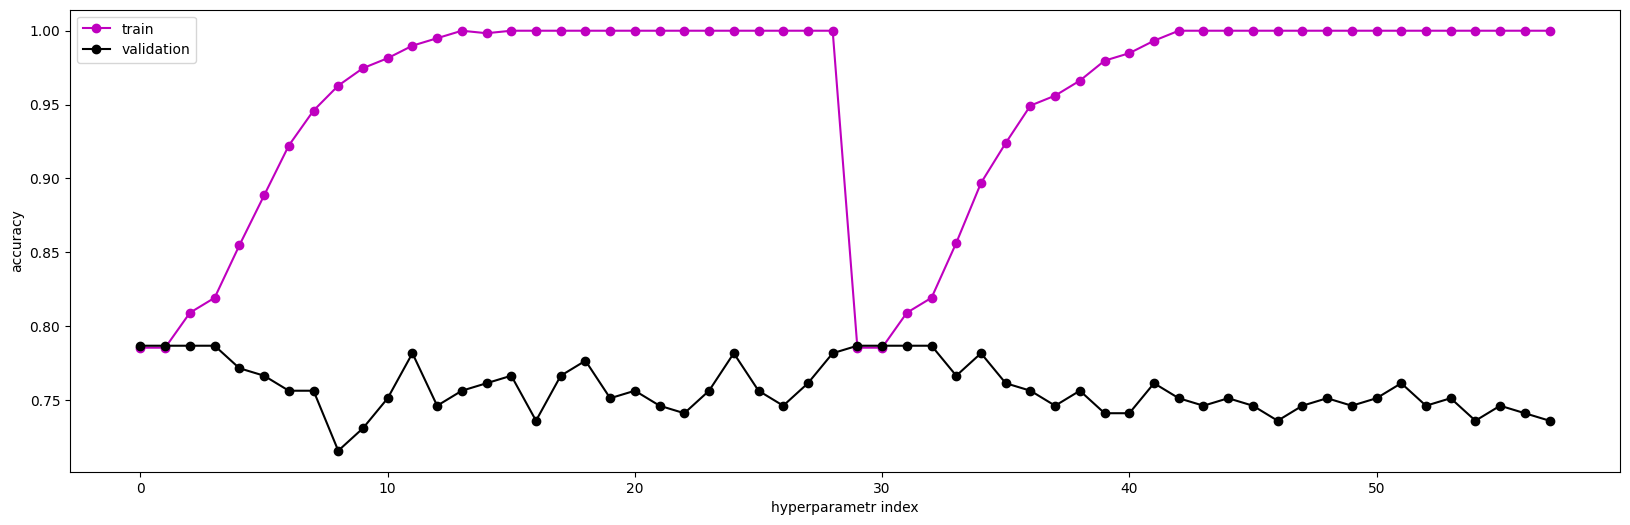

In [24]:
plt.figure(figsize=(20,6))
plt.plot(train_accuracy,'om-')
plt.plot(val_accuracy,'ok-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [25]:
best_params = param_comb[np.argmax(val_accuracy)]
print(best_params)
print('train accuracy: {0:.6f}'.format(train_accuracy[np.argmax(train_accuracy)]))
print('validation accuracy: {0:.6f}'.format(val_accuracy[np.argmax(val_accuracy)]))

{'max_depth': 1, 'criterion': 'entropy'}
train accuracy: 1.000000
validation accuracy: 0.786802


In [26]:
dtc = DecisionTreeClassifier(**best_params)
dtc.fit(xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dtc.predict(xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dtc.predict(xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dtc.predict(xtest))))

accuracy score (train): 0.785473
accuracy score (validation): 0.786802
accuracy score (test): 0.772727


###  Zkusím pomocí metody KNN zlepšit predikci modelu
Použiju `KNeighborsClassifier` z knihovny `sklearn`.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors = 10)
knc.fit(xtrain, ytrain)
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, knc.predict(xval))))

accuracy score (validation): 0.685279


Výsledek vylepším vyzkoušením Normalizace.

### Normalizace dat
Zkusím **min-max normalizaci**. 
To udělám pomocí třídy `MinMaxScaler` z modulu `sklearn.preprocessing`.

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Min-max scaler nafituju na trénovacích datech
scaler = MinMaxScaler()
xtrain_scaled = scaler.fit_transform(xtrain)

# Následně stejnou transformaci aplikuju na validační a testovací data
xval_scaled = scaler.transform(xval)
xtest_scaled = scaler.transform(xtest)

# Natrénuju model na transformovaných datech
knc = KNeighborsClassifier()
knc.fit(xtrain_scaled, ytrain)

print(f"accuracy score (validation) of normalized model: {knc.score(xval_scaled, yval):0.6f}")
print(f"accuracy score (test) of normalized model: {knc.score(xtest_scaled, ytest):0.6f}")

accuracy score (validation) of normalized model: 0.781726
accuracy score (test) of normalized model: 0.813131


### Grid search KNN: ladění více hyperparameterů
Chci projít hodnoty `n_neighbors`, možné hodnoty `weights` a `metric`.

In [29]:
param_grid_knn = {
    'n_neighbors': range(3, 35),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
param_comb_knn = ParameterGrid(param_grid_knn)

In [30]:
val_accuracy_knn = []
train_accuracy_knn = []

for params in param_comb_knn:
    knc = KNeighborsClassifier(n_neighbors = params['n_neighbors'], weights = params['weights'], metric = params['metric'])
    knc.fit(xtrain_scaled, ytrain)
    train_accuracy_knn.append(metrics.accuracy_score(ytrain, knc.predict(xtrain_scaled)))
    val_accuracy_knn.append(metrics.accuracy_score(yval, knc.predict(xval_scaled)))

In [31]:
best_params_knn = param_comb_knn[np.argmax(val_accuracy_knn)]
print(best_params_knn)
print('train accuracy: {0:.6f}'.format(train_accuracy_knn[np.argmax(train_accuracy_knn)]))
print('validation accuracy: {0:.6f}'.format(val_accuracy_knn[np.argmax(val_accuracy_knn)]))

{'weights': 'uniform', 'n_neighbors': 10, 'metric': 'euclidean'}
train accuracy: 1.000000
validation accuracy: 0.827411


In [32]:
knc = KNeighborsClassifier(**best_params_knn)
knc.fit(xtrain_scaled, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knc.predict(xtrain_scaled))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, knc.predict(xval_scaled))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, knc.predict(xtest_scaled))))

accuracy score (train): 0.812500
accuracy score (validation): 0.827411
accuracy score (test): 0.838384


 ### Závěr
 Vidím, že metoda KNN dává vyšší accuracy score testu než Rozhodovací strom, tedy 83.8% vs 77.2%
 Proto napočítám predikce pro data s datasetu `Evaluation.csv` pomocí KNN.

### Evaluation: základní přehled
* Nahraju data z datasetu `evaluation.csv` a prozkoumám tento dataset.

In [33]:
evaluation = pd.read_csv('evaluation.csv')
print('data shape: ' + str(evaluation.shape))
display(evaluation.head())
display(evaluation.describe())
display(evaluation.nunique())

data shape: (309, 12)


,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1000,1,"Wick, Miss. Mary Natalie",female,31.0,0,2,36928,164.8667,C7,S,"Youngstown, OH"
1,1001,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C,NaN
2,1002,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"Scituate, MA"
3,1003,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S,NaN
4,1004,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q,NaN


,ID,pclass,age,sibsp,parch,fare
count,309.000000,309.000000,249.000000,309.000000,309.000000,309.000000
mean,1154.000000,2.300971,29.479251,0.498382,0.388350,32.897708
std,89.344838,0.831619,14.976391,1.109652,0.840142,47.185050
min,1000.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,1077.000000,2.000000,20.000000,0.000000,0.000000,7.925000
50%,1154.000000,3.000000,28.000000,0.000000,0.000000,13.000000
75%,1231.000000,3.000000,39.000000,1.000000,0.000000,31.387500
max,1308.000000,3.000000,80.000000,8.000000,6.000000,263.000000


ID           309
pclass         3
name         309
sex            2
age           71
sibsp          7
parch          6
ticket       277
fare         156
cabin         66
embarked       3
home.dest    132
dtype: int64

### Příprava dat před použitím modelu
Oddělím sloupec `ID`, potom připojím ho k výsledku přežil/nepřežil v data frame.

In [34]:
evaluation_id = evaluation['ID']

evaluation = evaluation.drop(['ID', 'name'], axis=1)

#### Při přípravě datasetu `Evaluation.csv` provedu stejné operace, které jsem provedla při přípravě datasetu `Data.csv` : 
* Vypořádám se s chybějicí hodnoty.


In [35]:
evaluation = evaluation.replace('?', np.nan)
evaluation = evaluation.replace('-', np.nan)
evaluation = evaluation.replace('unknown', np.nan)
evaluation = evaluation.replace('Unknown', np.nan)

* Nahradím **'male'** a **'female'** na bool hodnoty.

In [36]:
evaluation.sex = (evaluation.sex == 'male')

* Převedu nečíselný příznak `embarked` na **one-hot encoding** reprezentaci.

In [37]:
evaluation = pd.get_dummies(evaluation, columns=['embarked'])

  * Všechny příznaky s hodnotami typu string nahradím číselnými kódy.
  * Převedu je na číselnou reprezentaci.


In [38]:
obj_columns = evaluation.select_dtypes('object').columns
evaluation[obj_columns] = evaluation[obj_columns].astype('category').apply(lambda x: x.cat.codes)

* Nahradím všechny chybějící hodnoty -1.

In [39]:
evaluation = evaluation.fillna('-1')

 * Dataset `Evaluation` normalizuju pro další predikci.

In [40]:
scaler = MinMaxScaler()
evaluation_scaled = scaler.fit_transform(evaluation)

Napočítám predikce pro normalizovaná data z souboru.

In [41]:
predicted = knc.predict(evaluation_scaled)

Predikce uložím do dvou sloupců: `ID`, `predikce přežití` do souboru **results.csv**.

In [42]:
predicted = pd.Series(data = predicted, name = 'survived')
predicted_df = pd.concat([evaluation_id, predicted], axis = 1)
predicted_df.to_csv('results.csv', index = False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4f2b6f5-ac89-435f-8d71-65e9f809695f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>